Using Machine Learning to decide what movie to watch! I have created a comprehensive dataset of all movies and a lot of metadata about them, such as the revenue generated by the actors, the director's max IMDB rating and the age of the lead actors.
I will use these features to model only my own personal ratings and build an ML model that tries to learn my taste and give me personal predictions.

In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer, OneHotEncoder, MultiLabelBinarizer, PolynomialFeatures, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error

In [16]:
# Data Preparation
# Read in datasets
movies_df = pd.read_csv('df_movies_tags.csv') #All movies from imdb
ratings_df = pd.read_csv('raza_ratings.csv', encoding='ANSI') #Movies I have rated
tags_df = pd.read_csv('raza_keywords.csv') #Tags for movies with keywords

# Extract unique tags
tags = set(tags_df['Tag'].tolist())

C:\Users\Raza\AppData\Local\Temp\ipykernel_1956\3901944081.py:3: DtypeWarning: Columns (22,23,25,27,30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  movies_df = pd.read_csv('df_movies_tags.csv') #All movies from imdb


In [17]:
movies_df.head()

,Unnamed: 0.1,Unnamed: 0,tconst,primaryTitle,originalTitle,startYear,runtimeMinutes,genres,imdbRating,imdbVotes,...,Friendship,Racism,Cool,War,Royalty,Disabled,Nazi,Beautiful,Animal,Erotic
0,0,0,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,1906.0,70.0,"Action,Adventure,Biography",6.0,794,...,0,0,0,0,0,0,0,0,0,0
1,1,1,tt0001892,Den sorte drøm,Den sorte drøm,1911.0,53.0,Drama,5.9,239,...,0,0,0,0,0,0,0,0,0,0
2,2,2,tt0002101,Cleopatra,Cleopatra,1912.0,100.0,"Drama,History",5.1,536,...,0,0,0,0,1,0,0,0,0,0
3,3,3,tt0002130,Dante's Inferno,L'Inferno,1911.0,71.0,"Adventure,Drama,Fantasy",7.0,2963,...,0,0,0,0,0,0,0,1,0,0
4,4,4,tt0002199,From the Manger to the Cross,From the Manger to the Cross,1912.0,60.0,"Biography,Drama",5.8,596,...,0,0,0,0,0,0,0,0,0,0


In [18]:
ratings_df.head()

,Title,Rating1,Rating2,Year,imdb
0,The Graduate,6.0,10,1967,tt0061722
1,Casablanca,6.0,10,1942,tt0034583
2,Elmer Gantry,6.0,10,1960,tt0053793
3,Dr Strangelove,6.0,10,1964,tt0057012
4,Naked,6.0,10,1993,tt0107653


In [19]:
tags_df.head()

,Tag,Keywords
0,Manipulate,manipulate
1,Cynical,cynical
2,Familia,"brother,cousin,mother,father,in-law,inlaw,clan..."
3,FamilyConflict,"manipulate,inheritance,widow,affair,feud,clan,..."
4,Marriage,"marry,marriage,divorce,bride,husband,wedding,g..."


In [20]:
# Split features into categories for processing
numeric_features = list({
    'startYear', 'runtimeMinutes', 'imdbRating', 'imdbVotes', 'tmdbPopularity', 'tmdbRating', 'tmdbCount',
    'dirImdbRating', 'dirImdbVotes', 'dirTop3ImdbRating', 'dirTop5ImdbRating', 'dirNFilms', 'dirMaxRating',
    'actor1ImdbVotes', 'actor1NFilms', 'actor2ImdbVotes', 'actor2NFilms', 'dirAge', 'dirFilmAge',
    'oneAge', 'secondAge', 'topTwoAge', 'topTwoAgeDiff', 'dirRatingDiff'
}.union(tags))

binned_features = [
    'budget', 'revenue', 'actor1Revenue', 'actor2Revenue', 'dirAvgRevenue', 
    'topTwoActorRevenue', 'topFourActorRevenue', 'dirRevenue'
]

categorical_features = ['actor1Gender', 'original_language', 'twoGender', 'fourGender']

# Drop columns without an imdb rating or that are missing developed features
movies_df = movies_df.dropna(subset=['imdbRating', 'actor1Gender'])

# Merge my ratings with the movies dataset
merged_df = (
    movies_df
    .merge(ratings_df.drop(columns='Year'), left_on='tconst', right_on='imdb', how='left')
    .assign(original_language=lambda df: df['original_language'].fillna('unknown'))
    .drop(columns=['tagline', 'Rating1'])
)

#Use Rating2 which is rating/10
label = 'Rating2'

In [21]:
# Replace missing values with 0
for feature in binned_features + numeric_features:
    merged_df[feature].fillna(0, inplace=True)

#Two main datasets, one with my ratings. This will be used to train a model. The other contains all movies and will later be used to predict ratings for movies I have not seen.
raza_df = merged_df[merged_df['Rating2'].notna()].copy()
all_df = merged_df.copy()



#Save the imdb ids for later joining and the labels
train_ids = raza_df['tconst'].to_list()
df_train_ids = pd.DataFrame(train_ids, columns=['tconst'])
label_data = raza_df[label]

# Create processing pipelines
numeric_pipeline = Pipeline([
    ('scaler', MinMaxScaler())
])

binned_pipeline = Pipeline([
    ('binner', KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform'))
])

categorical_pipeline = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

data_pipeline = ColumnTransformer([
    ('numerical', numeric_pipeline, numeric_features),
    ('binned', binned_pipeline, binned_features),
    ('categorical', categorical_pipeline, categorical_features)
])

# Transform both datasets using pipeline
raza_df = data_pipeline.fit_transform(raza_df)
categorical_feature_names = data_pipeline.named_transformers_['categorical']['encoder'].get_feature_names_out()
column_names = numeric_features + binned_features + list(categorical_feature_names)

raza_df = pd.DataFrame(raza_df, columns=column_names)

all_df = data_pipeline.transform(all_df)
all_df = pd.DataFrame(all_df, columns=column_names)

c:\Users\Raza\anaconda3\envs\whirlwind\lib\site-packages\sklearn\preprocessing\_discretization.py:239: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
c:\Users\Raza\anaconda3\envs\whirlwind\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import uniform, randint
from sklearn.linear_model import Lasso

#Create an ensemble model using Random Forest, Lasso Regression, and XGBoost

# Use 80/20 train/test split
X_train, X_test, y_train, y_test = train_test_split(
    raza_df, 
    label_data, 
    test_size=0.2, 
    random_state=42
)

# Random Forest Hyperparameter Tuning
# rf_param_dist = {
#     'n_estimators': [50, 100, 200],
#     'max_features': [None, 'sqrt', 'log2'],
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'bootstrap': [True, False]
# }

rf_param_dist = {
    'n_estimators': [50],
    'max_features': [None],
    'max_depth': [10],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'bootstrap': [True]
}

rf_random_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=rf_param_dist,
    n_iter=50,
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=42
)
rf_random_search.fit(X_train, y_train)
forest_model = rf_random_search.best_estimator_

# Lasso Regression Hyperparameter Tuning
# lasso_param_grid = {
#     'alpha': [0.001, 0.01, 0.1, 1.0, 10.0],
#     'max_iter': [1000, 2000, 5000]
# }

lasso_param_grid = {
    'alpha': [0.01],
    'max_iter': [1000]
}

lasso_grid_search = GridSearchCV(
    estimator=Lasso(random_state=42),
    param_grid=lasso_param_grid,
    cv=5,
    scoring='neg_mean_squared_error'
)
lasso_grid_search.fit(X_train, y_train)
lasso_model = lasso_grid_search.best_estimator_

# XGBoost Hyperparameter Tuning
# xgb_param_dist = {
#     'n_estimators': [50, 100, 200],
#     'learning_rate': [0.01, 0.03, 0.1],
#     'max_depth': [3, 5, 7],
#     'min_child_weight': [1, 3, 5],
#     'subsample': [0.6, 0.8, 1.0],
#     'colsample_bytree': [0.6, 0.8, 1.0]
# }
xgb_param_dist = {
    'n_estimators': [100],
    'learning_rate': [0.03],
    'max_depth': [3],
    'min_child_weight': [1],
    'subsample': [ 1.0],
    'colsample_bytree': [0.6]
}

xgb_random_search = RandomizedSearchCV(
    estimator=xgb.XGBRegressor(objective="reg:squarederror", random_state=42),
    param_distributions=xgb_param_dist,
    n_iter=50,
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=42
)
xgb_random_search.fit(X_train, y_train)
xgb_model = xgb_random_search.best_estimator_

print("Best Random Forest Parameters:", rf_random_search.best_params_)
print("Best Lasso Parameters:", lasso_grid_search.best_params_)
print("Best XGBoost Parameters:", xgb_random_search.best_params_)

# Generate predictions for each model
forest_preds_test = forest_model.predict(X_test)
lasso_model_preds_test = lasso_model.predict(X_test)
xgb_preds_test = xgb_model.predict(X_test)

forest_preds_all = forest_model.predict(all_df)
lasso_preds_all = lasso_model.predict(all_df)
xgb_preds_all = xgb_model.predict(all_df)

print('Random Forest MSE:', round(mean_squared_error(y_test, forest_preds_test), 2))
print('Lasso MSE:', round(mean_squared_error(y_test, lasso_model_preds_test), 2))
print('XGBoost MSE:', round(mean_squared_error(y_test, xgb_preds_test), 2))
print('Ensemble MSE:', round(mean_squared_error(y_test, X_test['Ensemble']), 2))

# Assign weights for each model in ensemble
forest_weight = 0.3
lasso_weight = 0.3
xgb_weight = 0.4

X_test['Forest'] = forest_preds_test
X_test['Lasso'] = lasso_model_preds_test
X_test['XGBoost'] = xgb_preds_test
X_test['Ensemble'] = X_test['Forest'] * forest_weight + X_test['Lasso'] * lasso_weight + X_test['XGBoost'] * xgb_weight

#Join originalat dataset information

X_test = X_test.merge(df_train_ids, left_index=True, right_index=True).merge(merged_df[['tconst', 'primaryTitle', 'Rating2']], left_on='tconst', right_on='tconst')

# Print top 5 movies for each model
print('Random Forest Top 5:')
print(X_test.sort_values(by='Forest', ascending=False).head(5)[['primaryTitle', 'Rating2', 'Forest']])
print('\n')
print('Lasso Top 5:')
print(X_test.sort_values(by='Lasso', ascending=False).head(5)[['primaryTitle', 'Rating2', 'Lasso']])
print('\n')
print('XGBoost Top 5:')
print(X_test.sort_values(by='XGBoost', ascending=False).head(5)[['primaryTitle', 'Rating2', 'XGBoost']])
print('\n')
print('Ensemble Top 5:')
print(X_test.sort_values(by='Ensemble', ascending=False).head(5)[['primaryTitle', 'Rating2', 'Ensemble']])
print('\n')

c:\Users\Raza\anaconda3\envs\whirlwind\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 1 is smaller than n_iter=50. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\Raza\anaconda3\envs\whirlwind\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 1 is smaller than n_iter=50. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Random Forest Parameters: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 10, 'bootstrap': True}
Best Lasso Parameters: {'alpha': 0.01, 'max_iter': 1000}
Best XGBoost Parameters: {'subsample': 1.0, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.03, 'colsample_bytree': 0.6}
Random Forest MSE: 2.6
Lasso MSE: 2.7
XGBoost MSE: 2.58
Ensemble MSE: 2.56
Random Forest Top 5:
                                       primaryTitle  Rating2    Forest
156                                    Forrest Gump      5.0  8.689435
120  Star Wars: Episode V - The Empire Strikes Back      9.0  8.404274
17    The Lord of the Rings: The Return of the King      9.0  8.354368
60                       Terminator 2: Judgment Day      8.0  7.966909
207                                    Day of Wrath      5.0  7.835265


Lasso Top 5:
                                       primaryTitle  Rating2     Lasso
156                       

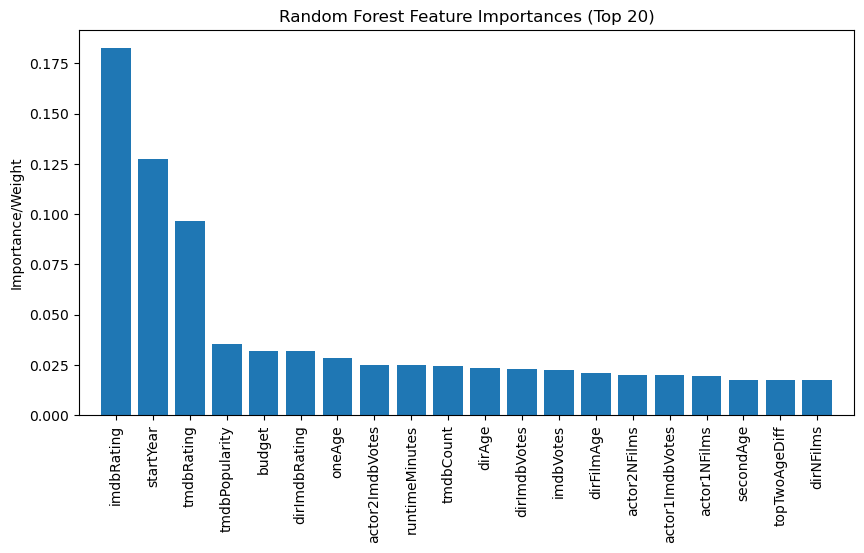

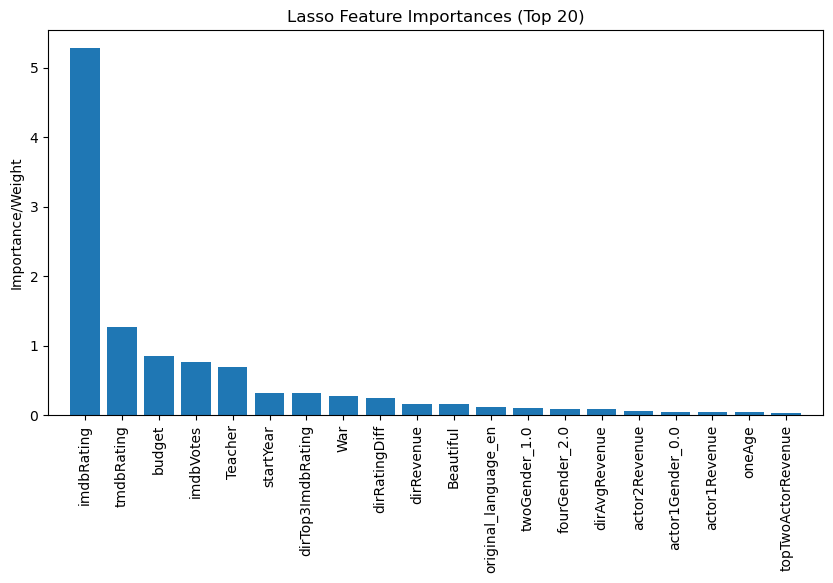

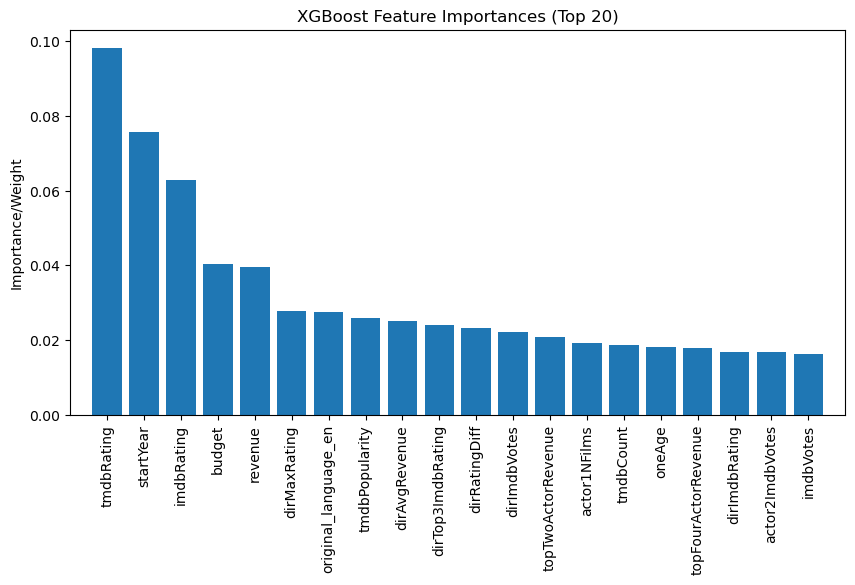

In [23]:
import matplotlib.pyplot as plt
import numpy as np

def plot_importances(importances, indices, columns, title):
    plt.figure(figsize=(10, 5))
    plt.title(title)
    plt.bar(range(len(indices)), importances[indices], align="center")
    plt.xticks(range(len(indices)), columns, rotation=90)
    plt.xlim([-1, len(indices)])
    plt.ylabel('Importance/Weight')
    plt.show()

# Random Forest
forest_importances = forest_model.feature_importances_
forest_indices = np.argsort(forest_importances)[::-1][:20]  # Top 20
forest_columns = raza_df.columns[forest_indices]
forest_values = forest_importances[forest_indices]

plot_importances(forest_importances, forest_indices, forest_columns, "Random Forest Feature Importances (Top 20)")


# Lasso
lasso_importances = np.abs(lasso_model.coef_)
lasso_indices = np.argsort(lasso_importances)[::-1][:20]  # Top 20
lasso_columns = raza_df.columns[lasso_indices]
lasso_values = lasso_importances[lasso_indices]

plot_importances(lasso_importances, lasso_indices, lasso_columns, "Lasso Feature Importances (Top 20)")

# XGBoost
xgb_importances = xgb_model.feature_importances_
xgb_indices = np.argsort(xgb_importances)[::-1][:20]  # Top 20
xgb_columns = raza_df.columns[xgb_indices]
xgb_values = xgb_importances[xgb_indices]

plot_importances(xgb_importances, xgb_indices, xgb_columns, "XGBoost Feature Importances (Top 20)")

In [ ]:
#Apply model to all films dataset
all_df['Forest'] = forest_preds_all
all_df['Lasso'] = lasso_preds_all
all_df['XGBoost'] = xgb_preds_all
all_df['Ensemble'] = all_df['Forest'] * forest_weight + all_df['Lasso'] * lasso_weight + all_df['XGBoost'] * xgb_weight
all_df = all_df.merge(merged_df[['tconst', 'primaryTitle', 'Rating2']], left_index=True, right_index=True)

In [46]:
#Show top 20 films of all time according to the ensemble model
all_df.sort_values(by='Ensemble', ascending=False).head(20)[['primaryTitle', 'Ensemble']]

,primaryTitle,Ensemble
31944,Pulp Fiction,8.241277
36145,The Matrix,8.229315
17798,The Godfather,8.200667
36441,Fight Club,8.154084
31599,Forrest Gump,8.151002
24785,Back to the Future,8.125178
35026,The Lord of the Rings: The Fellowship of the Ring,8.043768
20779,Star Wars: Episode IV - A New Hope,8.018062
38389,The Lord of the Rings: The Return of the King,7.928231
21402,Alien,7.904542


In [49]:
#Show top 10 unseen films according to the ensemble model
all_df[all_df['Rating2'].isna()].sort_values(by='Ensemble', ascending=False).head(10)[['primaryTitle', 'Ensemble']]

,primaryTitle,Ensemble
32903,Se7en,7.645002
33022,The Usual Suspects,7.577437
30422,Unforgiven,7.397304
43510,The Pianist,7.356567
32998,Toy Story,7.340535
63577,Sri Bharatha Baahubali,7.321440
44441,A Beautiful Mind,7.316705
1212,City Lights,7.260374
23333,The Marathon Family,7.256552
30873,Jurassic Park,7.184533
